Mounting Google Drive

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive /Colab Notebooks/Session 7')

In [ ]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torchvision

Updating Device to CUDA

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Importing custom modules

In [3]:
import utils
import model

In [4]:
from utils import *

In [5]:
from model import *

Defining data tranformations

In [6]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation((-10., 10.), fill=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])



Downloading MNIST dataset and splitting to train and test set

In [7]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:08<00:00, 19463056.26it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [8]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Creating Data Loaders from train data and test data

In [9]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

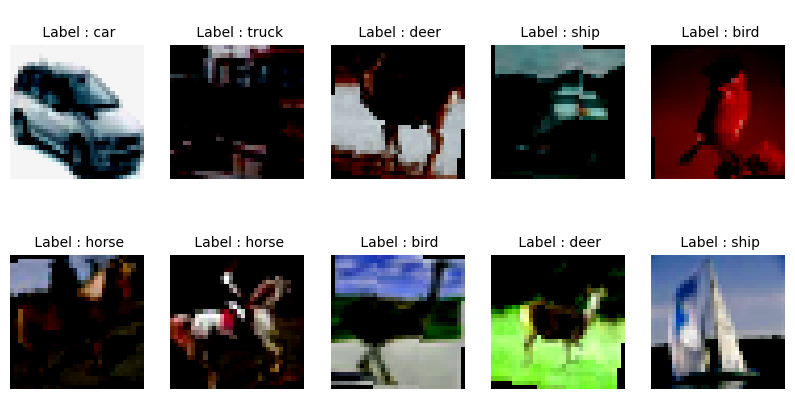

In [10]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
num_of_images = 10
fig = plt.figure(figsize=(10,5))

for index in range(1, num_of_images+1):
    ax = fig.add_subplot(2, 5, index)
    ax.axis('off')
    actual = classes[labels[index]]
    ax.set_title(f'\n Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(images[index], (1, 2, 0)))

## Data Statistics

Transferring model to GPU and printing model summary

In [12]:
model1 = Net(norm="LN").to(device)
summary(model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             160
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,440
             ReLU-12           [-1, 16, 16, 16]               0
        GroupNorm-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Training and evaluating the model with BatchNorm2d layers

In [15]:
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.10)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model1, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model1, device, test_loader)

EPOCH: 1


Loss=1.6845014095306396 Batch_id=97 Accuracy=27.61: 100%|██████████| 98/98 [00:45<00:00,  2.15it/s]



Test set: Average loss: 1.6922, Accuracy: 3779/10000 (37.79%)

EPOCH: 2


Loss=1.5081937313079834 Batch_id=97 Accuracy=40.97: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Test set: Average loss: 1.4914, Accuracy: 4530/10000 (45.30%)

EPOCH: 3


Loss=1.435294508934021 Batch_id=97 Accuracy=46.41: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]



Test set: Average loss: 1.4031, Accuracy: 4852/10000 (48.52%)

EPOCH: 4


Loss=1.2556670904159546 Batch_id=97 Accuracy=50.66: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Test set: Average loss: 1.2696, Accuracy: 5452/10000 (54.52%)

EPOCH: 5


Loss=1.1390116214752197 Batch_id=97 Accuracy=54.61: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 1.2272, Accuracy: 5581/10000 (55.81%)

EPOCH: 6


Loss=1.1293522119522095 Batch_id=97 Accuracy=56.82: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 1.1258, Accuracy: 5967/10000 (59.67%)

EPOCH: 7


Loss=1.118552565574646 Batch_id=97 Accuracy=59.30: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 1.1281, Accuracy: 5969/10000 (59.69%)

EPOCH: 8


Loss=1.1707735061645508 Batch_id=97 Accuracy=60.59: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 1.0366, Accuracy: 6299/10000 (62.99%)

EPOCH: 9


Loss=0.9533239006996155 Batch_id=97 Accuracy=62.22: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.9685, Accuracy: 6548/10000 (65.48%)

EPOCH: 10


Loss=1.115505576133728 Batch_id=97 Accuracy=63.27: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.9808, Accuracy: 6474/10000 (64.74%)

EPOCH: 11


Loss=0.9169056415557861 Batch_id=97 Accuracy=64.57: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.9557, Accuracy: 6651/10000 (66.51%)

EPOCH: 12


Loss=1.0258114337921143 Batch_id=97 Accuracy=65.11: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.9299, Accuracy: 6697/10000 (66.97%)

EPOCH: 13


Loss=0.9353869557380676 Batch_id=97 Accuracy=66.22: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.9331, Accuracy: 6670/10000 (66.70%)

EPOCH: 14


Loss=0.9459137916564941 Batch_id=97 Accuracy=67.15: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.8930, Accuracy: 6859/10000 (68.59%)

EPOCH: 15


Loss=0.7658134698867798 Batch_id=97 Accuracy=67.81: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.8716, Accuracy: 6890/10000 (68.90%)

EPOCH: 16


Loss=0.8099405169487 Batch_id=97 Accuracy=68.53: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.8686, Accuracy: 6920/10000 (69.20%)

EPOCH: 17


Loss=0.8792162537574768 Batch_id=97 Accuracy=68.98: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.8649, Accuracy: 6948/10000 (69.48%)

EPOCH: 18


Loss=0.761865496635437 Batch_id=97 Accuracy=69.42: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.8668, Accuracy: 6947/10000 (69.47%)

EPOCH: 19


Loss=0.8497636914253235 Batch_id=97 Accuracy=69.55: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.8476, Accuracy: 6935/10000 (69.35%)

EPOCH: 20


Loss=0.8646615147590637 Batch_id=97 Accuracy=70.58: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.8366, Accuracy: 7117/10000 (71.17%)



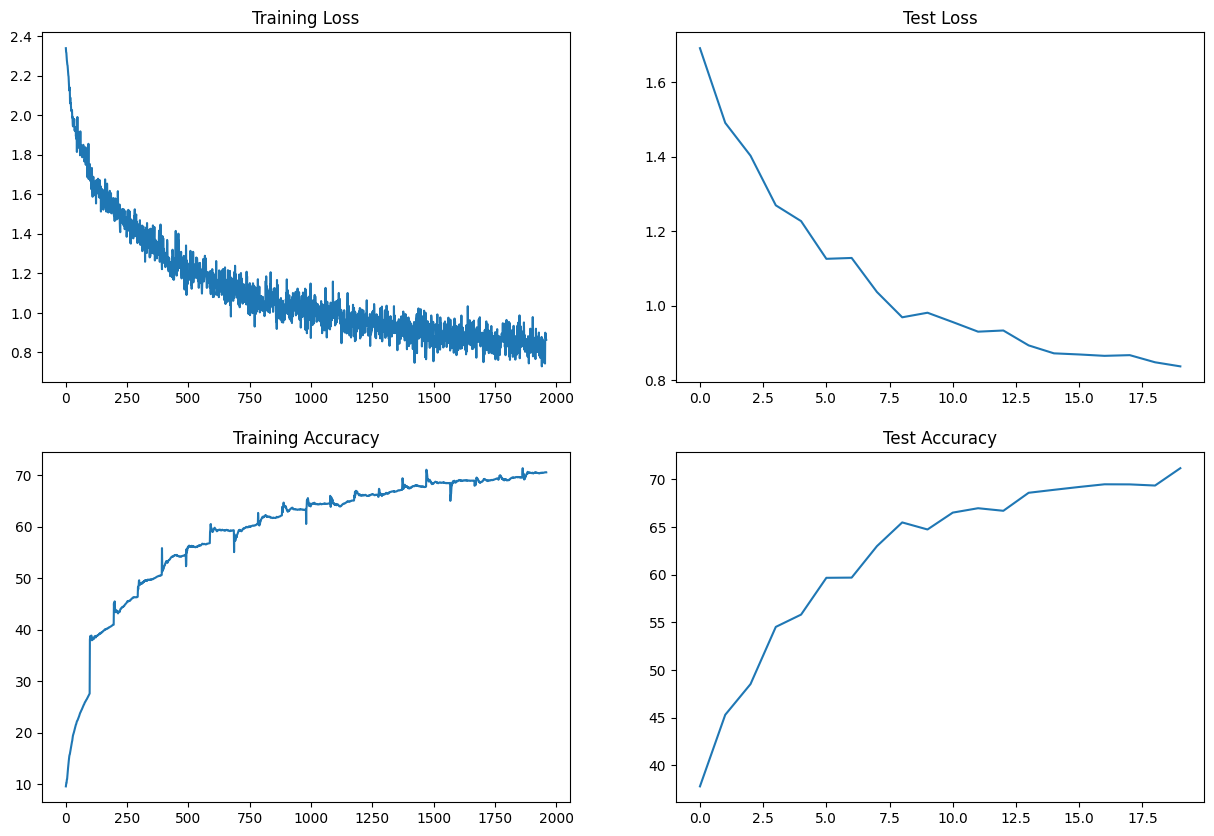

In [16]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

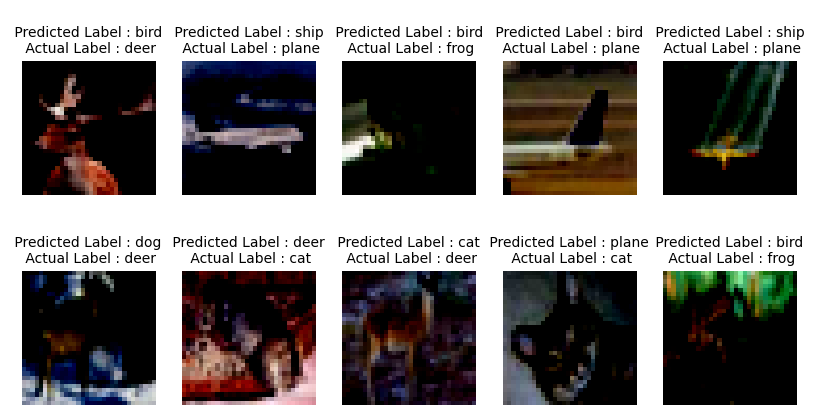

In [17]:
wrong_prediction_list = []
model1.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model1(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))

display_incorrect_images(wrong_prediction_list, n=10 )

# Target:

To achieve consistent 70% test accuracy with BatchNorm2d

# Results:
Parameters: 39,540

Best Training Accuracy: 75.18

Best Test Accuracy: 72.48

# Analysis:

Model is training well. Desired accuracy achieved from 7th epoch
Learning rate started from 0.2 and stepped down at every 6th epoch.